In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

In [2]:
# Load data
training_data = pd.read_json("train.json")
test_data = pd.read_json("test.json")

In [3]:
# Split data and set the appropriate columns
test_features = list(test_data.columns)

training_data = training_data.sample(frac=1)
Y = training_data['requester_received_pizza']
X = training_data[training_data.columns[training_data.columns.isin(test_features)]]

train_data, train_labels = X[:3609], Y[:3609]
val_data, val_labels = X[3609:], Y[3609:]

In [4]:
num_features = ['requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request']

In [5]:
def entropy(distribution):
    ''' Computes the entropy index
    # param distribution: list containing distributions
    # return entropy index
    '''
    entropy_index = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: 
            logprob = np.log2(probability)
        entropy_index -= probability * logprob
        
    return entropy_index

In [6]:
def get_parent_distribution(labels):
    ''' Computes parent distirbution
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    # Initialize counters for all labels to zero.
    label_probs = np.array([0.0 for i in range(len(np.unique(labels)))])

    # Iterate over labels in the training data and update counts.
    for label in labels:
        label_probs[label] += 1.0
    
    # Normalize to get a distribution.
    label_probs /= label_probs.sum()
    
    return label_probs

In [7]:
def information_gain(data, labels, feature, threshold=0):
    ''' Computes information gain
    # param data: an array of featurized examples
    # param labels: an array of labels corresponding to the the data
    # param feature: the feature to use to split the data
    # param threshold: the feature value to use to split the data (the default threshold is good for binary features)
    '''
    # Get the initial entropy of the label distribution.
    initial_entropy = entropy(get_parent_distribution(labels))
    
    # subset0 will contain the labels for which the feature is 0 and
    # subset1 will contain the labels for which the feature is 1.
    subset0, subset1 = [], []
    for datum, label in zip(data, labels):
        if datum[feature] > threshold:
            subset1.append(label)
        else: 
            subset0.append(label)
    
    # Compute the entropy of each subset.
    subset0_entropy = entropy(get_parent_distribution(subset0))
    subset1_entropy = entropy(get_parent_distribution(subset1))
    
    # Compute the final entropy by weighting each subset's entropy according to its size.
    subset0_weight = 1.0 * len(subset0) / len(labels)
    subset1_weight = 1.0 * len(subset1) / len(labels)
    final_entropy = subset0_weight * subset0_entropy + subset1_weight * subset1_entropy
    
    # Finally, compute information gain as the difference between the initial and final entropy.
    return initial_entropy - final_entropy

In [8]:
def try_features_and_thresholds(data, labels):
    ''' Computes thresholds for each features and returns the threshold that optimized information gain
    # param labels: << your turn to comment here >>
    # return: <<your turn to comment here >>
    '''
    print('feature', 'best_threshold', 'best_IG', 'feature name')
    for feature in range(data.shape[1]):
        # Choose a set of thresholds between the min- and max-valued feature, ignoring the min and max themselves.
        thresholds = np.linspace(data[:,feature].min(), data[:,feature].max(), 20)[1:-1]

        # Try each threshold and keep track of the best one for this feature.
        best_threshold = 0
        best_IG = 0
        for threshold in thresholds:
            IG = information_gain(data, labels, feature, threshold)
            if IG > best_IG:
                best_IG = IG
                best_threshold = threshold

        # Show the best threshold and information gain for this feature.
        
        print ('%d %.3f %.3f %s' %(feature, best_threshold, best_IG, features[feature]))

In [9]:
label_probs = get_parent_distribution(train_labels)

print ('Parent distribution', label_probs)
# Compare the label entropy to a uniform distribution.
print ('Parent entropy:', entropy(label_probs))
print ('Uniform entropy:', entropy([1./3, 1./3, 1./3]))

Parent distribution [0.5 0.5]
Parent entropy: 1.0
Uniform entropy: 1.584962500721156


In [10]:
train_data = train_data[train_data.columns[train_data.columns.isin(num_features)]]

In [11]:
val_data = val_data[val_data.columns[val_data.columns.isin(num_features)]]

Using a decision stump -- a tree with depth 1:
Feature importances: [0.         0.         0.         0.65215039 0.         0.
 0.         0.         0.34784961]
Accuracy: 0.7819025522041764


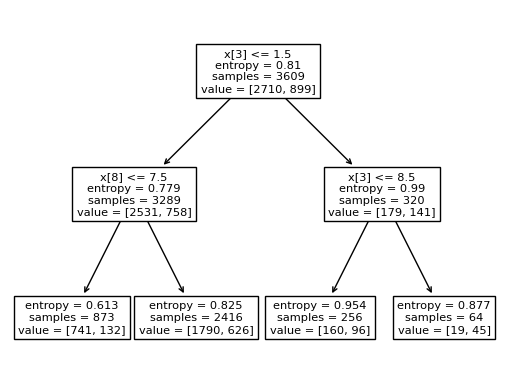

In [12]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(train_data, train_labels)
tree.plot_tree(dt)
print ('Using a decision stump -- a tree with depth 1:')
print ('Feature importances:', dt.feature_importances_)
print ('Accuracy:', dt.score(val_data, val_labels))

In [13]:
for i in range(len(num_features)):
    print(i, num_features[i])

0 requester_account_age_in_days_at_request
1 requester_days_since_first_post_on_raop_at_request
2 requester_number_of_comments_at_request
3 requester_number_of_comments_in_raop_at_request
4 requester_number_of_posts_at_request
5 requester_number_of_posts_on_raop_at_request
6 requester_number_of_subreddits_at_request
7 requester_upvotes_minus_downvotes_at_request
8 requester_upvotes_plus_downvotes_at_request


In [14]:
imp_features = [num_features[0], num_features[3], num_features[8]]